#**Pre-request**

##Mount google drive


In [1]:
### **Mount** Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Install pakages


In [2]:
#Install pakages
project_path = "/content/drive/MyDrive/Sem-6/coding/github/fraud_detection/"
!cat "{project_path}requirement/Install/EnhancedPretraindMLModleAdvance.txt"
!pip install  -r "{project_path}requirement/Install/EnhancedPretraindMLModleAdvance.txt" --no-cache-dir
%cd $project_path





torch
transformers
huggingface_hub
datasets
timm
patool
sktime
reformer_pytorchRequirement already satisfied: torch in /usr/local/lib/python3.12/dist-packages (from -r /content/drive/MyDrive/Sem-6/coding/github/fraud_detection/requirement/Install/EnhancedPretraindMLModleAdvance.txt (line 1)) (2.8.0+cu126)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 138.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.5/149.5 kB 384.9 MB/s eta 0:00:00
/content/drive/MyDrive/Sem-6/coding/github/fraud_detection


##Import  libs

In [3]:
# =====================================================
# 📦 Standard Library Imports
# =====================================================
import os
import yaml
import logging
import datetime
import sys


# =====================================================
# 🧮 Data & Visualization
# =====================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import data_table
data_table.enable_dataframe_formatter()

# Expand Colab’s table display limits
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

# =====================================================
# ⚙️ Machine Learning - Scikit-learn
# =====================================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Covariance for Mahalanobis distance
from sklearn.covariance import EmpiricalCovariance

# Evaluation metrics (all consolidated)
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    precision_recall_curve,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# =====================================================
# 🤖 Deep Learning - TensorFlow / Keras
# =====================================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# =====================================================
# 🔥 Deep Learning - PyTorch
# =====================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.cuda.amp import autocast

# =====================================================
# 🤗 Transformers & Advanced Models
# =====================================================
from transformers import AutoModel
# from mamba_ssm import Mamba  # Uncomment if used

# =====================================================
# 🧠 Explainability
# =====================================================
import shap

##Confirmation setup

In [4]:
!nvidia-smi                # confirm GPU
!pip show torch  # confirm versions
torch.manual_seed(42)


Tue Nov 11 03:07:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

##Config and Var

In [5]:

logger = logging.getLogger(__name__)

def load_config(config_path="configs/baseline.yaml"):
    """Load YAML config file and expand ${root_path} placeholders."""
    with open(config_path, "r") as f:
        config = yaml.safe_load(f)

    logger.info(f"✅ Loaded config from {config_path}")

    # --- Expand ${root_path} placeholders ---
    root = config.get("root_path", "")

    def expand_paths(obj):
        if isinstance(obj, dict):
            return {k: expand_paths(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [expand_paths(i) for i in obj]
        elif isinstance(obj, str) and "${root_path}" in obj:
            return obj.replace("${root_path}", root)
        else:
            return obj

    config = expand_paths(config)
    return config
config = load_config(os.path.join(project_path, "configs", "baseline.yaml"))


limit = config['ML']['limit']
max_seq_len = limit
time_mode='time2vec'
epochs = 10
batch_size=64
correlation_threshold = 0.85
threshold = 0.5
dropout= 0.0




##Split users level

In [6]:

user_path = config['ML']['Events']['base_path'] + config['ML']['Events']['files']['user']
df_user = pd.read_csv(user_path)
print(f"✅ Loaded transactional user dataset: {df_user.shape}")



# Aggregate to one row per user (max label = 1 if any fraud)
user_labels = df_user.groupby("phone_no_m")["label"].max()
print(f"👥 Unique users for splitting: {len(user_labels)}")

# ==============================================================
# 2️⃣ Create user-level split (stratified, no leakage)
# ==============================================================

fraud_users = user_labels[user_labels == 1].index
normal_users = user_labels[user_labels == 0].index

fraud_train, fraud_test = train_test_split(fraud_users, test_size=0.2, random_state=42)
normal_train, normal_test = train_test_split(normal_users, test_size=0.2, random_state=42)

train_users = set(fraud_train) | set(normal_train)
test_users  = set(fraud_test)  | set(normal_test)

# ==============================================================
# 3️⃣ Save unified split (shared across LSTM / RF / XGB)
# ==============================================================

split_dir = "splits"
os.makedirs(split_dir, exist_ok=True)

pd.DataFrame({"phone_no_m": sorted(train_users)}).to_csv(f"{split_dir}/train_users.csv", index=False)
pd.DataFrame({"phone_no_m": sorted(test_users)}).to_csv(f"{split_dir}/test_users.csv", index=False)

# ==============================================================
# 4️⃣ Summary
# ==============================================================

print("\n👥 Users Summary:")
print(f"   Total : {len(user_labels):,}")
print(f"   Fraud : {len(fraud_users):,} ({len(fraud_users)/len(user_labels)*100:.2f}%)")
print(f"   Normal: {len(normal_users):,} ({len(normal_users)/len(user_labels)*100:.2f}%)")

print("\n📂 Split saved to /splits/:")
print(f"   Train users: {len(train_users)}")
print(f"   Test  users: {len(test_users)}")
print(f"   Fraud ratio train: {len(fraud_train)/len(train_users)*100:.2f}%")
print(f"   Fraud ratio test : {len(fraud_test)/len(test_users)*100:.2f}%")


✅ Loaded transactional user dataset: (39454, 10)
👥 Unique users for splitting: 5929

👥 Users Summary:
   Total : 5,929
   Fraud : 1,788 (30.16%)
   Normal: 4,141 (69.84%)

📂 Split saved to /splits/:
   Train users: 4742
   Test  users: 1187
   Fraud ratio train: 30.16%
   Fraud ratio test : 30.16%


####Helpers

###Evaluate

In [7]:
def evaluate_global(model, X_test, y_test, model_name="Model"):
    """
    Generic evaluator for both classic ML models and neural networks (like LSTM).
    Automatically detects the correct prediction method.
    """
    # ---- Predict probabilities ----
    if hasattr(model, "predict_proba"):
        # For sklearn-style models
        y_pred_prob = model.predict_proba(X_test)[:, 1]
    else:
        # For neural nets (e.g., Keras)
        y_pred_prob = model.predict(X_test).ravel()

    # ---- Predict classes ----
    y_pred = (y_pred_prob > threshold).astype(int)

    # ---- Metrics ----
    auc = roc_auc_score(y_test, y_pred_prob)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, digits=4)
    cm = confusion_matrix(y_test, y_pred)

    # ---- Display ----
    print(f"\n📊 Classification Report — {model_name}")
    print(report)
    print(f"AUC: {auc:.4f} | Recall: {recall:.4f} | Precision: {precision:.4f} | F1: {f1:.4f}")

    # ---- Confusion Matrix ----
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal (0)", "Fraud (1)"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix — {model_name}")
    plt.grid(False)
    plt.show()

    # ---- Summary Dictionary ----
    return {
        "Model": model_name,
        "AUC": auc,
        "Recall": recall,
        "Precision": precision,
        "F1": f1
    }


### Summary

In [8]:

def append_to_summary(summary, model_name, results):
    """
    Appends or updates the summary table with model results.
    Works with both capitalized and lowercase keys automatically.
    """
    # ✅ Create summary DataFrame if missing
    if summary is None or not isinstance(summary, pd.DataFrame):
        summary = pd.DataFrame(columns=["Model", "AUC", "Recall", "Precision", "F1"])

    # ✅ Normalize key names to lowercase
    results = {k.lower(): v for k, v in results.items()}

    # ✅ Remove any existing row for the same model
    summary = summary[summary["Model"] != model_name]

    # ✅ Add new row (robust to missing values)
    row = {
        "Model": model_name,
        "AUC": round(results.get("auc", np.nan), 4) if not pd.isna(results.get("auc", np.nan)) else np.nan,
        "Recall": round(results.get("recall", np.nan), 4) if not pd.isna(results.get("recall", np.nan)) else np.nan,
        "Precision": round(results.get("precision", np.nan), 4) if not pd.isna(results.get("precision", np.nan)) else np.nan,
        "F1": round(results.get("f1", np.nan), 4) if not pd.isna(results.get("f1", np.nan)) else np.nan,
    }

    # ✅ Append and reindex
    summary = pd.concat([summary, pd.DataFrame([row])], ignore_index=True)
    summary = summary.reindex(columns=["Model", "AUC", "Recall", "Precision", "F1"])
    return summary


#ML Modules

##Classic Ml Snapshot based

###Load snapshots

In [9]:


snapshot_path = config['ML']['snapshot_input'] + config['ML']['snapshot_file']
df = pd.read_csv(snapshot_path)
max_snapshot = df["snapshot_index"].max()


print(f"Input data Max snapshot_index is : {max_snapshot}")

# Filter rows where snapshot_index <= 100
df = df[df["snapshot_index"] <= limit]
max_snapshot = df["snapshot_index"].max()

# Print the maximum snapshot_index before or equal to 100
print(f"Filtred Data Max snapshot_index is : {max_snapshot}")



print(f"✅ Loaded snapshot dataset: {df.shape}")

display((df.head()))

Input data Max snapshot_index is : 99
Filtred Data Max snapshot_index is : 50
✅ Loaded snapshot dataset: (301467, 33)


,phone_no_m,snapshot_index,snapshot_time,window_start,window_end,event_type,window_mode,window_size,voc_total_calls,voc_unique_contacts,voc_total_duration,voc_avg_duration,voc_max_duration,voc_std_duration,voc_active_days,voc_active_hours,sms_total_msgs,sms_unique_contacts,sms_active_hours,sms_calltype_ratio,app_months_active,app_total_flow,app_avg_flow,app_std_flow,app_unique_apps_mean,app_unique_apps_max,user_months_active,arpu_mean,arpu_std,arpu_max,idcard_cnt,snapshot_round,label
0,672ddbf02a5544d32e4ecc9433b1981bffe23bf912273a...,0,2019-08-01 08:17:49,2019-08-01 08:17:49,2019-08-01 08:17:49,VOC,time,10,1,1,13.0,13.0,13.0,0.0,1,1,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0
1,5e1272273e041e82cb275ae877710be98cdaf5b0a8f34d...,0,2019-08-01 00:11:56,2019-08-01 00:11:56,2019-08-01 00:11:56,SMS,time,10,0,0,0.0,0.0,0.0,0.0,0,0,1,1,1,0.0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0
2,eaab3472ec87b076e69e6e8bb62b14341638fc63661a6c...,0,2019-08-01 08:17:50,2019-08-01 08:17:50,2019-08-01 08:17:50,SMS,time,10,0,0,0.0,0.0,0.0,0.0,0,0,1,1,1,0.0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0
3,0ce1bb415704178bf44e9c9b431a39b083a132c8e6d99f...,0,2019-08-01 08:39:26,2019-08-01 08:39:26,2019-08-01 08:39:26,SMS,time,10,0,0,0.0,0.0,0.0,0.0,0,0,1,1,1,0.0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0
4,28b87f35f63f65096a53e3a4c97eaffd4a6c43ffa7e92d...,0,2019-08-01 09:22:56,2019-08-01 09:22:56,2019-08-01 09:22:56,VOC,time,10,1,1,6.0,6.0,6.0,0.0,1,1,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0


###Drop and select features

In [10]:
def prepare_features(df):
    """
    Selects only the explicitly defined features for model training.
    You control which features are used by editing 'selected_features' below.
    """

    # --- Define selected features manually ---
    selected_features = [
        "window_size", "voc_total_calls", "voc_unique_contacts", "voc_total_duration",
       "voc_avg_duration", "voc_max_duration", "voc_std_duration", "voc_active_days",
       "voc_active_hours", "sms_total_msgs", "sms_unique_contacts", "sms_active_hours",
       "sms_calltype_ratio", "app_months_active", "app_total_flow", "app_avg_flow",
       "app_std_flow", "app_unique_apps_mean", "app_unique_apps_max", "user_months_active",
        "arpu_mean", "arpu_std", "arpu_max", "idcard_cnt", "snapshot_round"
   ]
  #  selected_features = [
   #     "voc_total_calls", "voc_unique_contacts", "voc_total_duration",
    #   "voc_avg_duration", "voc_max_duration", "voc_std_duration", "voc_active_days",
     # "voc_active_hours", "sms_total_msgs", "sms_unique_contacts", "sms_active_hours",
     #"sms_calltype_ratio", "idcard_cnt"
    #]
   # selected_features = [
    #    "voc_active_days",
    #"voc_active_hours",
    #"voc_unique_contacts",
    #"sms_calltype_ratio",
    #"sms_active_hours" ]


    # ✅ You can manually remove or comment out features here
    # For example:
    # selected_features = [f for f in selected_features if not (f.startswith("app_") or f.startswith("arpu_"))]

    # --- Keep only existing columns ---
    available = [f for f in selected_features if f in df.columns]
    missing = [f for f in selected_features if f not in df.columns]

    X = df[available].copy()

    #print(f"\n📊 Final features used ({len(available)}): {available}")
    if missing:
        print(f"⚠️ Missing columns not found in data: {missing}")

    return X


###Split for snapshot based

In [11]:


# ==============================================================
# 1️⃣ Load or Create Unified User Split
# ==============================================================

split_dir = "splits"
train_split_file = f"{split_dir}/train_users.csv"
test_split_file  = f"{split_dir}/test_users.csv"

if os.path.exists(train_split_file) and os.path.exists(test_split_file):
    print("📂 Using existing user split from file...")
    train_users = set(pd.read_csv(train_split_file)["phone_no_m"])
    test_users  = set(pd.read_csv(test_split_file)["phone_no_m"])
else:
    print("🆕 Creating new unified user split...")
    os.makedirs(split_dir, exist_ok=True)

    user_labels = df.groupby("phone_no_m")["label"].max()
    fraud_users  = user_labels[user_labels == 1].index
    normal_users = user_labels[user_labels == 0].index

    fraud_train, fraud_test = train_test_split(fraud_users, test_size=0.2, random_state=42)
    normal_train, normal_test = train_test_split(normal_users, test_size=0.2, random_state=42)

    train_users = set(fraud_train) | set(normal_train)
    test_users  = set(fraud_test)  | set(normal_test)

    pd.DataFrame({"phone_no_m": sorted(train_users)}).to_csv(train_split_file, index=False)
    pd.DataFrame({"phone_no_m": sorted(test_users)}).to_csv(test_split_file, index=False)
    print(f"✅ Saved user split to '{split_dir}/'")

print(f"✅ Train users: {len(train_users)} | Test users: {len(test_users)}")

# ==============================================================
# 2️⃣ Apply User Split to Snapshot Data
# ==============================================================

train_df = df[df["phone_no_m"].isin(train_users)]
test_df  = df[df["phone_no_m"].isin(test_users)]

assert len(set(train_df["phone_no_m"]) & set(test_df["phone_no_m"])) == 0, "❌ User leakage detected!"
assert train_df["label"].nunique() == 2, "❌ Training set must contain both classes"
assert test_df["label"].nunique() == 2, "❌ Test set must contain both classes"

print(f"\n👥 User Summary:")
print(f"   Train users: {len(train_users):,}")
print(f"   Test  users: {len(test_users):,}")

print(f"\n📊 Event Split Summary:")
for name, df_part in [("Train", train_df), ("Test", test_df)]:
    total = len(df_part)
    fraud = df_part["label"].sum()
    print(f"   {name:5s} → {total:,} snapshots | Fraud: {fraud/total*100:.2f}% | Normal: {(1 - fraud/total)*100:.2f}%")

# ==============================================================
# 3️⃣ Feature Preparation
# ==============================================================



# Case 1: include app* and arpu* columns
X_train = prepare_features(train_df)
X_test  = prepare_features(test_df)


# Case 2: exclude app* and arpu* columns
# X_train = prepare_features(train_df, use_app_arpu=False)
# X_test  = prepare_features(test_df, use_app_arpu=False)


# Align features (ensure same structure)
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

y_train = train_df["label"].astype(int)
y_test  = test_df["label"].astype(int)

# ==============================================================
# 4️⃣ Full Dataset Scan + Scaling
# ==============================================================

# Combine all snapshots (for robust scaling reference)
all_data = pd.concat([train_df, test_df], axis=0)
print(f"\n📦 Scanning full dataset for scaling — total rows: {len(all_data):,}, columns: {len(all_data.columns)}")

numeric_cols = X_train.columns  # only use columns actually selected for the model
summary = all_data[numeric_cols].describe().T


# Select columns to scale (exclude binary or constants)
scale_cols = [
    c for c in numeric_cols
    if (summary.loc[c, "max"] - summary.loc[c, "min"]) > 5 and summary.loc[c, "max"] > 1
]
scale_cols = [c for c in scale_cols if c in X_train.columns]

print("\n📊 Numeric feature summary (before scaling):")
print(summary[["min", "max", "mean"]].round(2).sort_values("max", ascending=False))

print("\n📏 Selected for scaling (auto-detected based on range):")
print(scale_cols)

# Apply scaling
scaler = RobustScaler().fit(all_data[scale_cols])
X_train[scale_cols] = scaler.transform(X_train[scale_cols])
X_test[scale_cols]  = scaler.transform(X_test[scale_cols])

print("\n✅ Scaled snapshot features successfully.")
print(f"   Scaled columns: {len(scale_cols)} of {X_train.shape[1]} total features.")

# ==============================================================
# 5️⃣ Final Sanity Checks
# ==============================================================

print("\n✅ Feature Matrices Ready:")
print(f"   X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"   X_test : {X_test.shape}, y_test : {y_test.shape}")

print("\n🔒 Consistency Check: ✅ Same users used for all models (LSTM, RF, XGBoost).")


📂 Using existing user split from file...
✅ Train users: 4742 | Test users: 1187

👥 User Summary:
   Train users: 4,742
   Test  users: 1,187

📊 Event Split Summary:
   Train → 241,212 snapshots | Fraud: 30.02% | Normal: 69.98%
   Test  → 60,255 snapshots | Fraud: 29.91% | Normal: 70.09%

📦 Scanning full dataset for scaling — total rows: 301,467, columns: 33

📊 Numeric feature summary (before scaling):
                       min       max    mean
voc_total_duration     0.0  24868.00  677.26
app_total_flow         0.0  22893.31    4.86
app_avg_flow           0.0  22893.31    4.86
voc_max_duration       0.0   8524.00  242.25
voc_avg_duration       0.0   6728.00   71.13
voc_std_duration       0.0   6008.99   74.39
arpu_max               0.0    301.00    0.41
arpu_mean              0.0    301.00    0.41
voc_total_calls        0.0     51.00    7.19
app_unique_apps_mean   0.0     51.00    0.33
app_unique_apps_max    0.0     51.00    0.33
sms_total_msgs         0.0     51.00   16.24
sms_unique

###Corrleation for snapshots

📊 Correlation Matrix — Snapshot Features (XGBoost & RF)


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


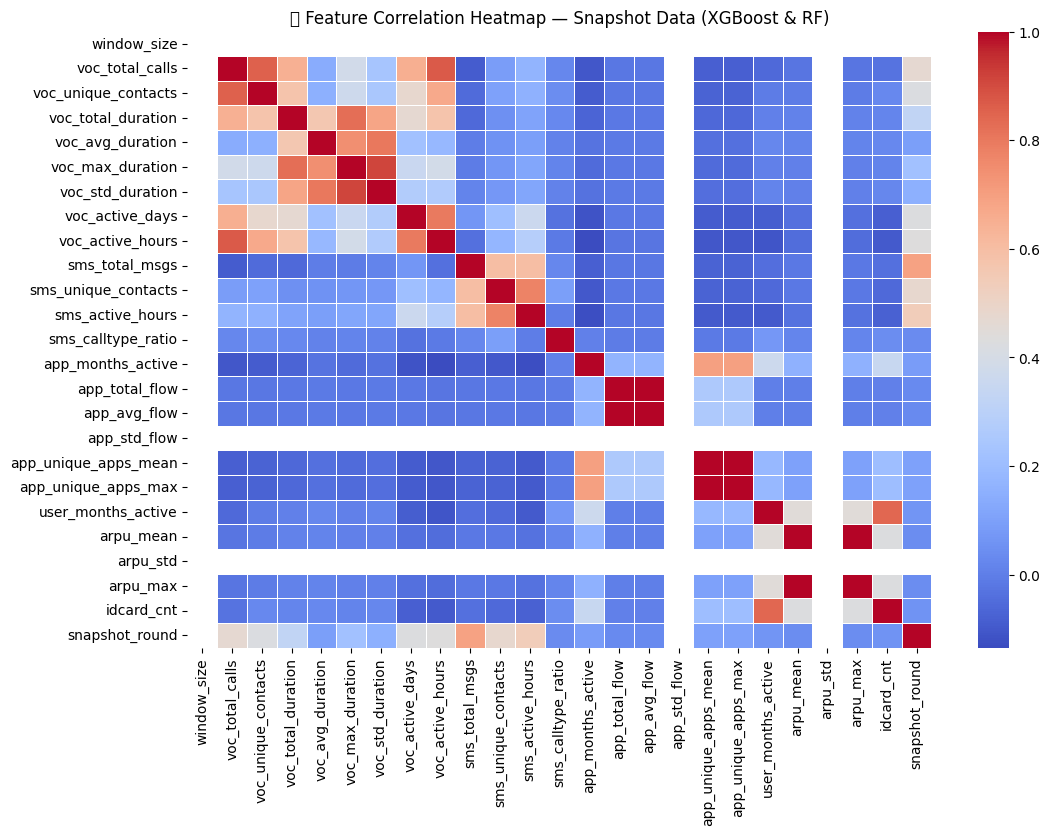

,Feature1,Feature2,Correlation
0,voc_total_calls,voc_unique_contacts,0.855285
6,voc_total_calls,voc_active_hours,0.871166
78,voc_max_duration,voc_std_duration,0.913821
195,app_total_flow,app_avg_flow,1.000000
210,app_unique_apps_mean,app_unique_apps_max,1.000000
225,arpu_mean,arpu_max,1.000000


In [12]:

# --- Snapshot correlation (XGBoost & RF) ---
print("📊 Correlation Matrix — Snapshot Features (XGBoost & RF)")

corr_snapshot = X_train.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_snapshot, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title("📊 Feature Correlation Heatmap — Snapshot Data (XGBoost & RF)")
plt.show()

# Optional: List highly correlated pairs



corr_pairs = (
    corr_snapshot.where(np.triu(np.ones(corr_snapshot.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
corr_pairs.columns = ["Feature1", "Feature2", "Correlation"]
high_corr_snapshot = corr_pairs[corr_pairs["Correlation"].abs() > correlation_threshold]
display(high_corr_snapshot)


###XGBoost model and training

In [13]:

xgb_model  = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    eval_metric='auc',
    scale_pos_weight=2.6,
    min_child_weight=1,
    gamma=0.1
    #--tree_method='gpu_hist',
    #--predictor='gpu_predictor'

)
print("🚀 Training XGBoost...")
xgb_model .fit(X_train, y_train)


🚀 Training XGBoost...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-1, num_parallel_tree=None, ...)

###RF model and training

In [14]:
# ✅ Train Random Forest in parallel
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)

print("🌲 Training Random Forest...")
rf_model.fit(X_train, y_train)





🌲 Training Random Forest...


RandomForestClassifier(max_depth=10, min_samples_leaf=3, min_samples_split=5,
                       n_estimators=300, n_jobs=-1, random_state=42)

###Testing

In [15]:

snapshot_indices = []
snapshot_metrics_xgb = []
snapshot_metrics_rf = []
recalls_xgb = []
recalls_rf = []
f1s_xgb, f1s_rf = [], []


for snap_idx, group in test_df.groupby('snapshot_index'):
    y_true = group['label']
    if y_true.nunique() < 2:
        continue

    X_snap = prepare_features(group)
    X_snap = X_snap.reindex(columns=X_train.columns, fill_value=0)

    # 🔹 XGBoost
    y_pred_xgb = xgb_model.predict_proba(X_snap)[:, 1]
    auc_xgb = roc_auc_score(y_true, y_pred_xgb)
    rec_xgb = recall_score(y_true, (y_pred_xgb > threshold).astype(int))
    f1_xgb  = f1_score(y_true, (y_pred_xgb > threshold).astype(int))


    # 🔹 Random Forest
    y_pred_rf = rf_model.predict_proba(X_snap)[:, 1]
    auc_rf = roc_auc_score(y_true, y_pred_rf)
    rec_rf = recall_score(y_true, (y_pred_rf > threshold).astype(int))
    f1_rf  = f1_score(y_true, (y_pred_rf > threshold).astype(int))


    # Append results
    snapshot_indices.append(snap_idx)
    snapshot_metrics_xgb.append(auc_xgb)
    snapshot_metrics_rf.append(auc_rf)
    recalls_xgb.append(rec_xgb)
    recalls_rf.append(rec_rf)
    f1s_xgb.append(f1_xgb)
    f1s_rf.append(f1_rf)


###Report


📊 Classification Report — XGBoost
              precision    recall  f1-score   support

           0     0.8722    0.7915    0.8299     42232
           1     0.5985    0.7283    0.6571     18023

    accuracy                         0.7726     60255
   macro avg     0.7354    0.7599    0.7435     60255
weighted avg     0.7904    0.7726    0.7782     60255

AUC: 0.8216 | Recall: 0.7283 | Precision: 0.5985 | F1: 0.6571


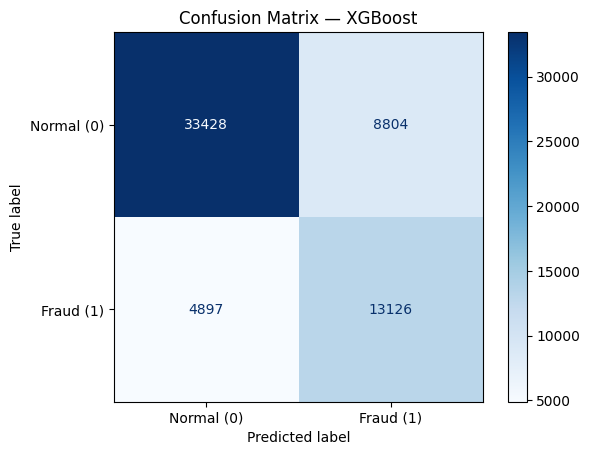


📊 Classification Report — Random Forest
              precision    recall  f1-score   support

           0     0.8272    0.9035    0.8637     42232
           1     0.7115    0.5577    0.6253     18023

    accuracy                         0.8001     60255
   macro avg     0.7693    0.7306    0.7445     60255
weighted avg     0.7926    0.8001    0.7924     60255

AUC: 0.8188 | Recall: 0.5577 | Precision: 0.7115 | F1: 0.6253


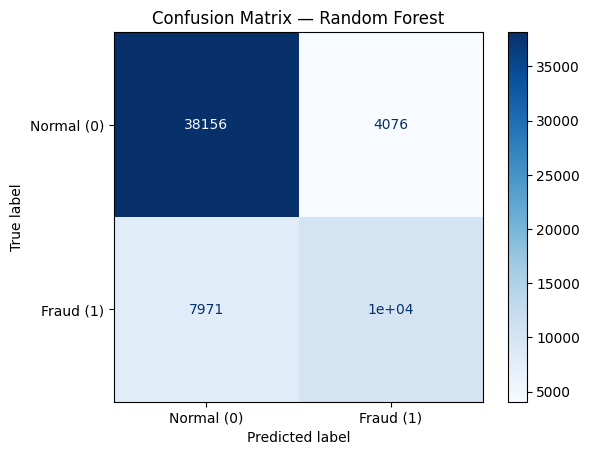


📋 Global Model Comparison Summary:


/tmp/ipython-input-2670903096.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary = pd.concat([summary, pd.DataFrame([row])], ignore_index=True)


,Model,AUC,Recall,Precision,F1
0,XGBoost,0.8216,0.7283,0.5985,0.6571
1,Random Forest,0.8188,0.5577,0.7115,0.6253


/tmp/ipython-input-2258892836.py:53: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


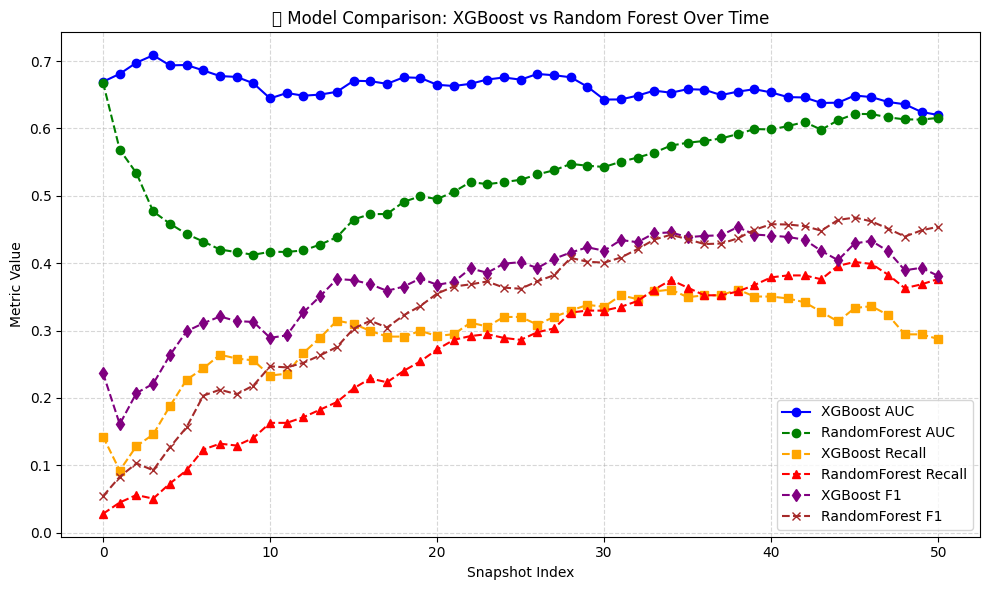

In [16]:
# =====================================================
# ✅ Model Evaluations — Unified Format
# =====================================================

# # Evaluate models using the unified evaluator
# xgb_results = evaluate_global(xgb_model, X_test, y_test, model_name="XGBoost")
# rf_results  = evaluate_global(rf_model,  X_test, y_test, model_name="Random Forest")

# # =====================================================
# # ✅ Global Model Comparison Summary
# # =====================================================
# summary = pd.DataFrame([xgb_results, rf_results])
# print("\n📋 Global Model Comparison Summary:")
# display(summary)

xgb_results = evaluate_global(xgb_model, X_test, y_test, model_name="XGBoost")
rf_results  = evaluate_global(rf_model,  X_test, y_test, model_name="Random Forest")

# =====================================================
# ✅ Append results to the global summary
# =====================================================
summary = append_to_summary(None, "XGBoost", xgb_results)
summary = append_to_summary(summary, "Random Forest", rf_results)

# =====================================================
# ✅ Display Global Model Comparison Summary
# =====================================================
print("\n📋 Global Model Comparison Summary:")
display(summary)

# =====================================================
# 📊 2. Model Comparison — XGBoost vs Random Forest
# =====================================================
plt.figure(figsize=(10, 6))

# --- AUC ---
plt.plot(snapshot_indices, snapshot_metrics_xgb, 'b-o', label='XGBoost AUC')
plt.plot(snapshot_indices, snapshot_metrics_rf, 'g--o', label='RandomForest AUC')

# --- Recall ---
plt.plot(snapshot_indices, recalls_xgb, color='orange', marker='s', linestyle='--', label='XGBoost Recall')
plt.plot(snapshot_indices, recalls_rf, color='red', marker='^', linestyle='--', label='RandomForest Recall')

# --- F1 ---
plt.plot(snapshot_indices, f1s_xgb, color='purple', marker='d', linestyle='--', label='XGBoost F1')
plt.plot(snapshot_indices, f1s_rf, color='brown', marker='x', linestyle='--', label='RandomForest F1')

plt.title('📈 Model Comparison: XGBoost vs Random Forest Over Time')
plt.xlabel('Snapshot Index')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



### Feature Importance

,Feature,Importance
6,voc_active_days,757.102234
7,voc_active_hours,275.989838
1,voc_unique_contacts,164.277603
10,sms_active_hours,147.711533
22,snapshot_round,119.101768
17,user_months_active,115.921974
11,sms_calltype_ratio,114.681908
9,sms_unique_contacts,73.297722
3,voc_avg_duration,69.416306
0,voc_total_calls,63.827320


/tmp/ipython-input-928906833.py:32: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


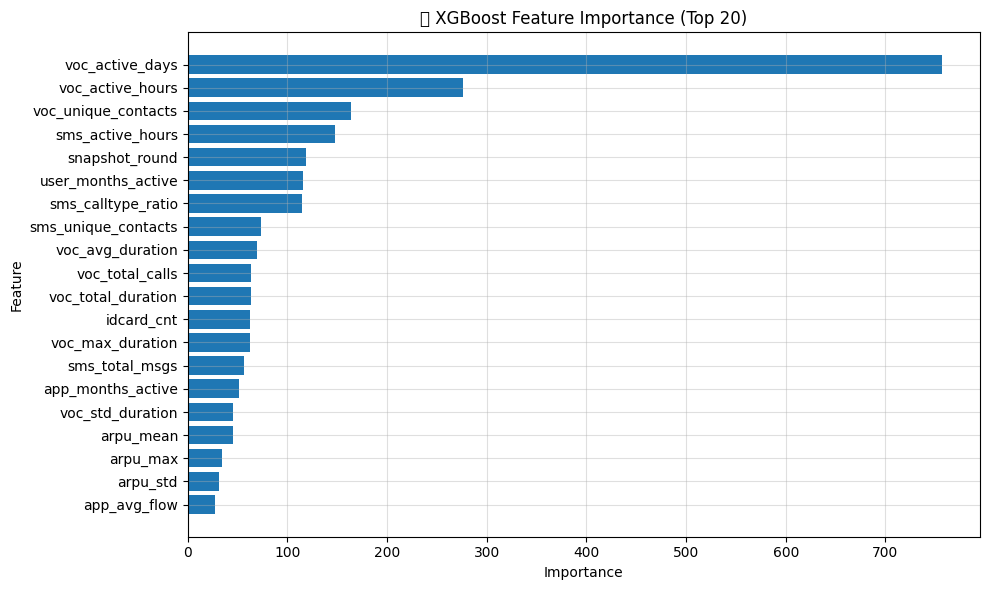

,Feature,Importance
7,voc_active_days,0.142179
8,voc_active_hours,0.135800
2,voc_unique_contacts,0.104210
11,sms_active_hours,0.085063
4,voc_avg_duration,0.064005
3,voc_total_duration,0.063096
24,snapshot_round,0.058843
12,sms_calltype_ratio,0.058744
1,voc_total_calls,0.057009
5,voc_max_duration,0.044127


/tmp/ipython-input-928906833.py:32: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


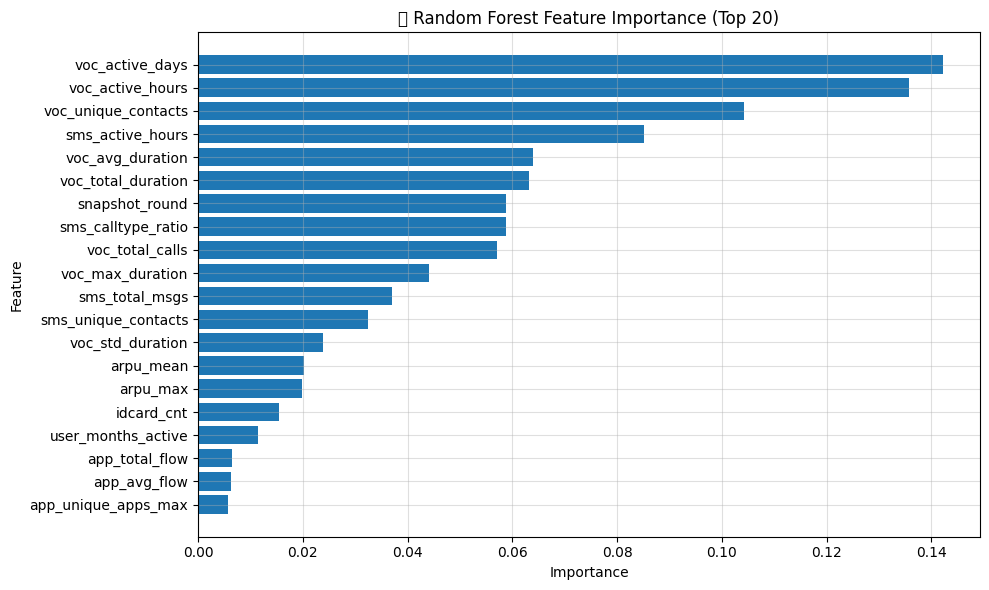

In [17]:
def plot_feature_importance(model, X_train, model_name="Model", top_n=20):
    """
    Plot feature importance for tree-based models (XGBoost, RandomForest).
    """


    # Handle model type
    if hasattr(model, "get_booster"):  # XGBoost
        importance = model.get_booster().get_score(importance_type='gain')
        fi = pd.DataFrame({
            'Feature': list(importance.keys()),
            'Importance': list(importance.values())
        })
    elif hasattr(model, "feature_importances_"):  # RandomForest
        fi = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': model.feature_importances_
        })
    else:
        raise ValueError(f"{model_name} does not support feature importance extraction.")

    # Sort and plot
    fi = fi.sort_values(by='Importance', ascending=False)
    display(fi.head(10))

    plt.figure(figsize=(10,6))
    plt.barh(fi['Feature'][:top_n][::-1], fi['Importance'][:top_n][::-1])
    plt.title(f'📊 {model_name} Feature Importance (Top {top_n})')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.grid(alpha=0.4)
    plt.tight_layout()
    plt.show()

    return fi

fi_xgb = plot_feature_importance(xgb_model, X_train, "XGBoost")
fi_rf = plot_feature_importance(rf_model, X_train, "Random Forest")


##Advance ML

####Generate timeline

#####Load

In [18]:
def load_raw_datasets(config):


    if "ML" in config and "Events" in config["ML"]:
        events_cfg = config["ML"]["Events"]
    else:
        events_cfg = config["Events"]

    base = events_cfg["base_path"]
    files = events_cfg["files"]

    # --- Load all datasets ---
    df_voc = pd.read_csv(os.path.join(base, files["voc"]))
    df_sms = pd.read_csv(os.path.join(base, files["sms"]))
    df_app = pd.read_csv(os.path.join(base, files["app"]))
    df_user = pd.read_csv(os.path.join(base, files["user"]))

    # --- Normalize timestamps and add source column ---
    for df, src in [(df_voc, "VOC"), (df_sms, "SMS"), (df_app, "APP"), (df_user, "USER")]:
        df["source"] = src
        ts_col = [c for c in df.columns if "time" in c.lower()][0]
        df.rename(columns={ts_col: "event_time"}, inplace=True)
        df["event_time"] = pd.to_datetime(df["event_time"], errors="coerce")

    print("✅ Raw datasets loaded and timestamp-normalized.")
    return df_voc, df_sms, df_app, df_user

df_voc, df_sms, df_app, df_user = load_raw_datasets(config)


✅ Raw datasets loaded and timestamp-normalized.


#####Define user sequence

In [19]:

def make_user_sequences(events, feature_cols=None, max_seq_len=100):
    """
    Build per-user sequences for LSTM models.
    Each user's events are sorted by time and padded/truncated to fixed length.

    Parameters
    ----------
    events : pd.DataFrame
        Combined event dataset (all sources).
    feature_cols : list or None
        List of numeric columns to include as features.
        If None, uses all numeric columns except 'label'.
    max_seq_len : int
        Sequence length to pad/truncate to.

    Returns
    -------
    X_seq : np.ndarray
        Array of shape (n_users, max_seq_len, n_features)
    y : np.ndarray
        Array of shape (n_users,)
    users : list
        List of user IDs
    """
    events = events.copy()
    users, X_seq, y = [], [], []

    # 🔹 Encode categorical 'source' column numerically
    le = LabelEncoder()
    events["source_id"] = le.fit_transform(events["source"].astype(str))

    # 🔹 Determine feature columns
    if feature_cols is None:
        feature_cols = events.select_dtypes(include=["number"]).columns.difference(["label"]).tolist()
    if "source_id" not in feature_cols:
        feature_cols.append("source_id")

    print(f"\n📦 Using {len(feature_cols)} features: {feature_cols}")


    # ✅ Build per-user sequences
    for user, df_u in events.groupby("phone_no_m"):
        df_u = df_u.sort_values("event_time")

        feats = df_u[feature_cols].to_numpy(dtype=float)

        # Pad or truncate
        if len(feats) < max_seq_len:
            feats = np.pad(feats, ((max_seq_len - len(feats), 0), (0, 0)))
        else:
            feats = feats[-max_seq_len:]

        # User label = any fraud event → fraud
        label = int(df_u["label"].max())

        X_seq.append(feats)
        y.append(label)
        users.append(user)

    print(f"\n✅ Created sequences for {len(users)} users")
    print(f"   Fraud users: {sum(y)} ({np.mean(y)*100:.2f}%)")
    print(f"   Normal users: {len(y) - sum(y)} ({(1 - np.mean(y))*100:.2f}%)")

    X_seq = np.array(X_seq)
    y = np.array(y)

    print(f"\n📐 Final tensor shape: X={X_seq.shape}, y={y.shape}")
    return X_seq, y, users


#####Build timeline (events)

In [20]:
def merge_and_prepare_events(df_voc, df_sms, df_app, df_user):

    # --- 1️⃣ Normalize USER dataset ---
    if 'label' not in df_user.columns:
        raise KeyError("❌ 'label' column not found in user dataset")

    # Ensure numeric consistency
    df_user['label'] = df_user['label'].fillna(0).astype(int)
    df_user['idcard_cnt'] = df_user['idcard_cnt'].fillna(0).astype(float)
    df_user['arpu_value'] = df_user['arpu_value'].fillna(0).astype(float)

    # --- 2️⃣ Extract static info for merging (label + sim count only) ---
    static_user_info = df_user.groupby("phone_no_m", as_index=False)[["label", "idcard_cnt"]].max()

    # --- 3️⃣ Merge static info into other event tables ---
    df_voc = df_voc.merge(static_user_info, on="phone_no_m", how="left")
    df_sms = df_sms.merge(static_user_info, on="phone_no_m", how="left")
    df_app = df_app.merge(static_user_info, on="phone_no_m", how="left")


    # --- 4️⃣ Combine all transactional event sources ---
    # include df_user itself since arpu_value is event-like
    events = pd.concat([df_voc, df_sms, df_app, df_user], ignore_index=True)
    # ✅ Keep only transactional events (VOC + SMS)
    #Drop app and user fee
    #events = pd.concat([df_voc, df_sms], ignore_index=True)

    # --- 5️⃣ Fill and order ---
    events["label"] = events["label"].fillna(0).astype(int)
    events["event_time"] = pd.to_datetime(events["event_time"], errors="coerce")
    events = events.sort_values(["phone_no_m", "event_time"]).reset_index(drop=True)

    # --- 6️⃣ Summary ---
    print("\n🔎 Feature Summary per Source:")
    for src, df in [("VOC", df_voc), ("SMS", df_sms), ("APP", df_app), ("USER", df_user)]:
        print(f"\n📂 Source: {src}")
        print(f"   Events: {len(df):,}")
        print(f"   Users : {df['phone_no_m'].nunique():,}")
        print(f"   Columns ({len(df.columns)}): {', '.join(df.columns)}")

    print("\n📊 Combined Dataset Summary:")
    print(f"   Total events: {len(events):,}")
    print(f"   Unique users: {events['phone_no_m'].nunique():,}")
    print(f"   Fraud ratio: {events['label'].mean()*100:.2f}%")

    return events

events = merge_and_prepare_events(df_voc, df_sms, df_app, df_user)



🔎 Feature Summary per Source:

📂 Source: VOC
   Events: 5,015,430
   Users : 6,025
   Columns (11): phone_no_m, opposite_no_m, calltype_id, event_time, call_dur, city_name, county_name, imei_m, source, label, idcard_cnt

📂 Source: SMS
   Events: 6,848,509
   Users : 6,103
   Columns (7): phone_no_m, opposite_no_m, calltype_id, event_time, source, label, idcard_cnt

📂 Source: APP
   Events: 3,283,602
   Users : 6,106
   Columns (10): phone_no_m, event_time, source, busi_name, flow, month_id, flow_norm, month_str, label, idcard_cnt

📂 Source: USER
   Events: 39,454
   Users : 5,929
   Columns (10): phone_no_m, event_time, source, month_id, arpu_value, city_name, county_name, idcard_cnt, label, month_col

📊 Combined Dataset Summary:
   Total events: 15,186,995
   Unique users: 6,106
   Fraud ratio: 23.90%


#####Split data based on users (fraud, not fraud)

In [21]:


# ======================================
# 0️⃣ Clean Numeric Columns
# ======================================
events = events.copy()
numeric_cols = events.select_dtypes(include=["number"]).columns.difference(["label"])

# Replace NaN with 0 for numeric fields (avoids scaling issues)
events[numeric_cols] = events[numeric_cols].fillna(0)

print(f"\n📊 Numeric columns to scale ({len(numeric_cols)}): {numeric_cols.tolist()}")

# ======================================
# 1️⃣ Scale Numeric Features
# ======================================
scaler_seq = StandardScaler()
events[numeric_cols] = scaler_seq.fit_transform(events[numeric_cols])
print(f"📏 Scaled {len(numeric_cols)} numeric columns for event-level modeling.")

# ======================================
# 2️⃣ Create Train/Test User Split (if not exists)
# ======================================
split_dir = "splits"
train_split_file = f"{split_dir}/train_users.csv"
test_split_file = f"{split_dir}/test_users.csv"

os.makedirs(split_dir, exist_ok=True)

if os.path.exists(train_split_file) and os.path.exists(test_split_file):
    print("📂 Using existing user split from file...")
    train_users = set(pd.read_csv(train_split_file)["phone_no_m"])
    test_users  = set(pd.read_csv(test_split_file)["phone_no_m"])
else:
    print("🆕 Creating new unified user split (for LSTM)...")

    # One label per user
    user_labels = events.groupby("phone_no_m")["label"].max()
    fraud_users = user_labels[user_labels == 1].index
    normal_users = user_labels[user_labels == 0].index

    fraud_train, fraud_test = train_test_split(fraud_users, test_size=0.2, random_state=42)
    normal_train, normal_test = train_test_split(normal_users, test_size=0.2, random_state=42)

    train_users = set(fraud_train) | set(normal_train)
    test_users  = set(fraud_test)  | set(normal_test)

    pd.DataFrame({"phone_no_m": sorted(train_users)}).to_csv(train_split_file, index=False)
    pd.DataFrame({"phone_no_m": sorted(test_users)}).to_csv(test_split_file, index=False)
    print(f"✅ Saved user split to '{split_dir}/'")

print(f"✅ Train users: {len(train_users)} | Test users: {len(test_users)}")

# ======================================
# 3️⃣ Apply Split to Events
# ======================================
train_events = events[events["phone_no_m"].isin(train_users)]
test_events  = events[events["phone_no_m"].isin(test_users)]

# --- add time gap, scaled featur ---
for name, df in [('train_events', train_events), ('test_events', test_events)]:
    df = df.copy()  # avoid SettingWithCopyWarning
    df['event_time'] = pd.to_datetime(df['event_time'])
    df.sort_values(['phone_no_m', 'event_time'], inplace=True)
    df['dt_hours'] = df.groupby('phone_no_m')['event_time'].diff().dt.total_seconds() / 3600
    df['dt_hours'] = df['dt_hours'].fillna(0)
    df['dt_hours'] = np.log1p(df['dt_hours'])  # normalize gaps
    if name == 'train_events':
        train_events = df
    else:
        test_events = df


# Sanity checks
assert len(set(train_events["phone_no_m"]) & set(test_events["phone_no_m"])) == 0, "❌ User leakage detected!"
assert train_events["label"].nunique() == 2, "❌ Training set must contain both classes"
assert test_events["label"].nunique() == 2, "❌ Test set must contain both classes"

# ======================================
# 4️⃣ Create Sequences (using multiple features)
# ======================================
numeric_features = [c for c in numeric_cols if c not in ["label"]]  # exclude label
if 'dt_hours' in train_events.columns:
    numeric_features.append('dt_hours')
print(f"\n📦 Features used for sequences: {numeric_features}")

X_train, y_train, users_train = make_user_sequences(train_events, feature_cols=numeric_features, max_seq_len=max_seq_len)
X_test, y_test, users_test = make_user_sequences(test_events, feature_cols=numeric_features, max_seq_len=max_seq_len)

print("\n✅ Sequence Summary (per-user sequences):")
print(f"   X_train: {X_train.shape} | Fraud ratio: {np.mean(y_train)*100:.2f}%")
print(f"   X_test : {X_test.shape} | Fraud ratio: {np.mean(y_test)*100:.2f}%")

# ======================================
# 5️⃣ Consistency Check
# ======================================
rf_train = set(pd.read_csv(train_split_file)["phone_no_m"])
rf_test  = set(pd.read_csv(test_split_file)["phone_no_m"])
assert rf_train == train_users, "❌ Train user mismatch between LSTM and RF/XGB!"
assert rf_test  == test_users,  "❌ Test user mismatch between LSTM and RF/XGB!"
print("\n🔒 Consistency Check: ✅ Same users used for all models (LSTM, RF, XGBoost).")



📊 Numeric columns to scale (6): ['arpu_value', 'call_dur', 'calltype_id', 'flow', 'flow_norm', 'idcard_cnt']
📏 Scaled 6 numeric columns for event-level modeling.
📂 Using existing user split from file...
✅ Train users: 4742 | Test users: 1187

📦 Features used for sequences: ['arpu_value', 'call_dur', 'calltype_id', 'flow', 'flow_norm', 'idcard_cnt', 'dt_hours']

📦 Using 8 features: ['arpu_value', 'call_dur', 'calltype_id', 'flow', 'flow_norm', 'idcard_cnt', 'dt_hours', 'source_id']

✅ Created sequences for 4742 users
   Fraud users: 1430 (30.16%)
   Normal users: 3312 (69.84%)

📐 Final tensor shape: X=(4742, 50, 8), y=(4742,)

📦 Using 8 features: ['arpu_value', 'call_dur', 'calltype_id', 'flow', 'flow_norm', 'idcard_cnt', 'dt_hours', 'source_id']

✅ Created sequences for 1187 users
   Fraud users: 358 (30.16%)
   Normal users: 829 (69.84%)

📐 Final tensor shape: X=(1187, 50, 8), y=(1187,)

✅ Sequence Summary (per-user sequences):
   X_train: (4742, 50, 8) | Fraud ratio: 30.16%
   X_tes

#####Correlation raw data

📊 Correlation Matrix — Raw Event Features (LSTM)


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


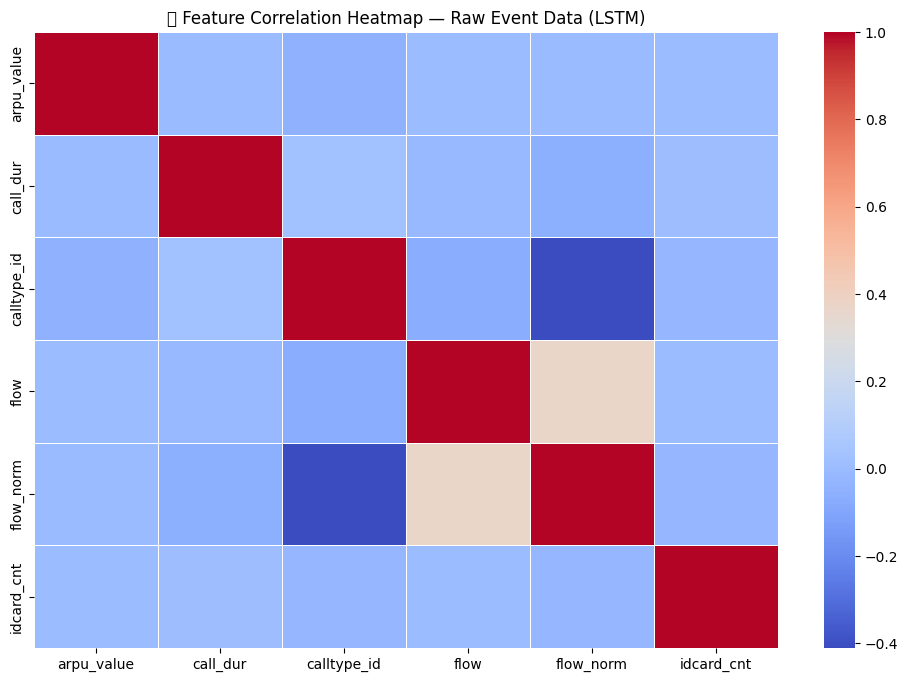

,Feature1,Feature2,Correlation


In [22]:
# --- LSTM correlation ---
print("📊 Correlation Matrix — Raw Event Features (LSTM)")

corr_lstm = pd.DataFrame(events[numeric_cols]).corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_lstm, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title("📊 Feature Correlation Heatmap — Raw Event Data (LSTM)")
plt.show()

# Optional: Highly correlated pairs

corr_pairs_lstm = (
    corr_lstm.where(np.triu(np.ones(corr_lstm.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
corr_pairs_lstm.columns = ["Feature1", "Feature2", "Correlation"]
high_corr_lstm = corr_pairs_lstm[corr_pairs_lstm["Correlation"].abs() > correlation_threshold]
display(high_corr_lstm)


#####Class weights

In [23]:

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))
print(class_weights)

{0: np.float64(0.7158816425120773), 1: np.float64(1.658041958041958)}


### RNN - LSTM ▶



#####F1 Calculation

In [24]:

def f1_metric(y_true, y_pred):
    # Convert both tensors to float32 before math operations
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(K.round(y_pred), 'float32')

    tp = K.sum(y_true * y_pred)
    fp = K.sum((1 - y_true) * y_pred)
    fn = K.sum(y_true * (1 - y_pred))

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


#####Model and training

In [25]:


# ======================================
# 4️⃣ Build and train LSTM model
# ======================================

lstm_model = Sequential([
    Masking(mask_value=0.0, input_shape=(max_seq_len, X_train.shape[2])),
    LSTM(128, return_sequences=False, use_cudnn=False),
    Dropout(dropout),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])


lstm_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(1e-4),
    metrics=['AUC', 'Recall',f1_metric]
)

print("🚀 Training LSTM...")
lstm_history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs , batch_size=batch_size,
    class_weight=class_weights

)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🚀 Training LSTM...
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - AUC: 0.7916 - Recall: 0.6898 - f1_metric: 0.3288 - loss: 0.6228 - val_AUC: 0.8925 - val_Recall: 0.8017 - val_f1_metric: 0.3207 - val_loss: 0.4575
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.9052 - Recall: 0.7905 - f1_metric: 0.3054 - loss: 0.4083 - val_AUC: 0.9100 - val_Recall: 0.8045 - val_f1_metric: 0.2953 - val_loss: 0.3214
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.9129 - Recall: 0.7755 - f1_metric: 0.2781 - loss: 0.3339 - val_AUC: 0.9163 - val_Recall: 0.8184 - val_f1_metric: 0.2901 - val_loss: 0.2953
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.9235 - Recall: 0.8068 - f1_metric: 0.2953 - loss: 0.3144 - val_AUC: 0.9192 - val_Recall: 0.8268 - val_f1_metric: 0.2979 - val_loss: 0.2905
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.9250 - Recall: 0.8015 - f1_metric: 0.2858 - loss: 0.3033 - val_AUC: 0.9239 - val_Recall: 0.8184 - val_f1_metric: 0.2858 - val_los

##### Testing

In [26]:

# Predict probabilities and labels
y_pred_prob = lstm_model.predict(X_test).ravel()


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


#####Report

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

📊 Classification Report — LSTM
              precision    recall  f1-score   support

           0     0.9282    0.9517    0.9398       829
           1     0.8813    0.8296    0.8547       358

    accuracy                         0.9149      1187
   macro avg     0.9048    0.8907    0.8973      1187
weighted avg     0.9141    0.9149    0.9142      1187

AUC: 0.9292 | Recall: 0.8296 | Precision: 0.8813 | F1: 0.8547


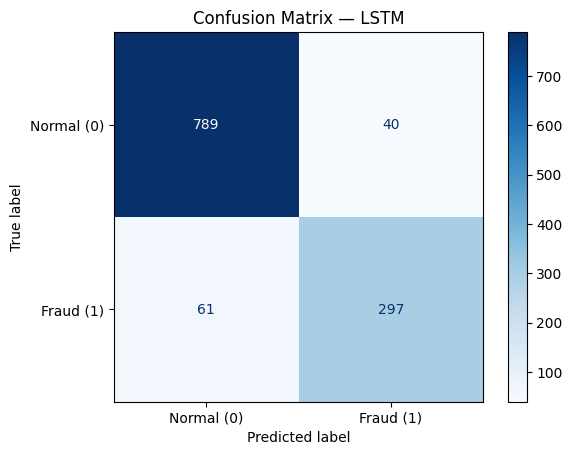


📋 Updated Model Comparison Summary:


,Model,AUC,Recall,Precision,F1
0,XGBoost,0.8216,0.7283,0.5985,0.6571
1,Random Forest,0.8188,0.5577,0.7115,0.6253
2,LSTM,0.9292,0.8296,0.8813,0.8547


In [27]:
# Threshold predictions (if binary classification)
y_pred = (y_pred_prob > threshold).astype(int)

# Evaluate LSTM model using the unified evaluator
lstm_results = evaluate_global(lstm_model, X_test, y_test, model_name="LSTM")

# Add to global summary (no need for checks)
summary = append_to_summary(summary, "LSTM", lstm_results)

# Display updated summary
print("\n📋 Updated Model Comparison Summary:")
display(summary)


/tmp/ipython-input-370801462.py:25: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


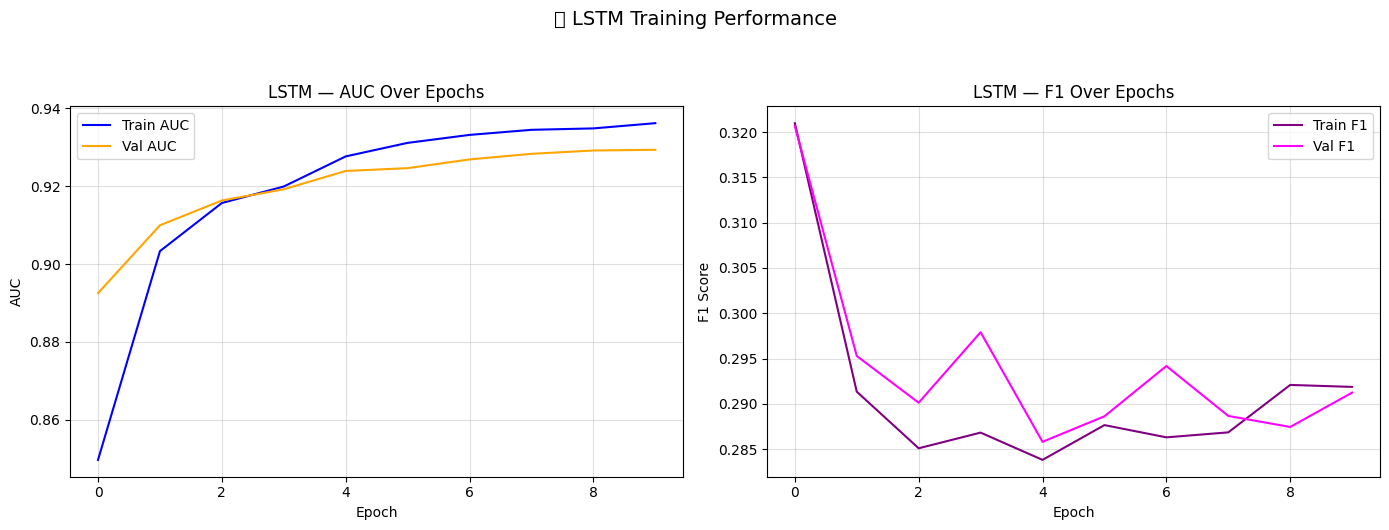

In [28]:
# =====================================================
# 📈 1. LSTM Training Metrics (AUC + F1)
# =====================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- AUC Plot ---
axes[0].plot(lstm_history.history['AUC'], label='Train AUC', color='blue')
axes[0].plot(lstm_history.history['val_AUC'], label='Val AUC', color='orange')
axes[0].set_title('LSTM — AUC Over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('AUC')
axes[0].legend()
axes[0].grid(True, alpha=0.4)

# --- F1 Plot ---
axes[1].plot(lstm_history.history['f1_metric'], label='Train F1', color='purple')
axes[1].plot(lstm_history.history['val_f1_metric'], label='Val F1', color='magenta')
axes[1].set_title('LSTM — F1 Over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1 Score')
axes[1].legend()
axes[1].grid(True, alpha=0.4)

plt.suptitle('📊 LSTM Training Performance', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()


###Transformer

####Build sequence

In [29]:
# ==============================================================
# NEW: Transformer helpers (no changes to existing LSTM path)
# ==============================================================


def build_tf_sequences(events, feature_cols=None, max_seq_len=100):
    """
    Build Transformer-ready sequences with:
      - X_seq:      [n_users, T, F]   numeric features
      - DT_seq:     [n_users, T, 1]   delta-time (hours) feature
      - PAD_mask:   [n_users, T]      True where PAD
      - y_user:     [n_users]         user labels
      - users:      list              phone_no_m
    NOTE: This is separate from make_user_sequences(); it does not replace it.
    """
    events = events.copy()
    users, X_seq, DT_seq, PAD_mask, y_user = [], [], [], [], []
    D_seq = []

    # Ensure numeric source_id exists (you already add it elsewhere)
    if "source_id" not in events.columns:

        le = LabelEncoder()
        events["source_id"] = le.fit_transform(events["source"].astype(str))

    # Default: all numeric except label
    if feature_cols is None:
        feature_cols = events.select_dtypes(include=["number"]).columns.difference(["label"]).tolist()
    if "source_id" not in feature_cols:
        feature_cols.append("source_id")

    for user, df_u in events.groupby("phone_no_m"):
        df_u = df_u.sort_values("event_time")

        # delta-time in hours between events (0 for first)
        #dt_hours = df_u["event_time"].diff().dt.total_seconds().fillna(0) / 3600.0
        #dt_hours = dt_hours.to_numpy(dtype=float).reshape(-1, 1)
        # ✅ use already-computed normalized dt_hours
        dt_hours = df_u["dt_hours"].to_numpy(dtype=float).reshape(-1, 1)



        feats = df_u[feature_cols].to_numpy(dtype=float)
        L = len(feats)

        # Build padding mask: True where PAD (we left-pad to keep most recent)
        if L < max_seq_len:
            pad_len = max_seq_len - L
            feats   = np.pad(feats,   ((pad_len, 0), (0, 0)))
            dt_hours= np.pad(dt_hours,((pad_len, 0), (0, 0)))
            pad_mask = np.zeros((max_seq_len,), dtype=bool)
            pad_mask[:pad_len] = True
        else:
            feats    = feats[-max_seq_len:]
            dt_hours = dt_hours[-max_seq_len:]
            pad_mask = np.zeros((max_seq_len,), dtype=bool)

        label = int(df_u["label"].max())

        X_seq.append(feats)
        DT_seq.append(dt_hours)
        PAD_mask.append(pad_mask)
        y_user.append(label)
        users.append(user)
        D_seq.append(df_u['dt_hours'].values[-max_seq_len:])



    X_seq   = np.stack(X_seq)
    DT_seq  = np.stack(DT_seq)
    PAD_mask= np.stack(PAD_mask)
    y_user  = np.array(y_user, dtype=int)
    return X_seq, DT_seq, PAD_mask, y_user, users


print("\n🧪 [Transformer] Building sequences...")
max_seq_len_tf = limit

# Build Transformer-ready sequences (no leakage; uses your existing train/test splits)
Xtr_raw, DTr_raw, Mtr, ytr, users_tr = build_tf_sequences(train_events, max_seq_len=max_seq_len_tf)
Xte_raw, DTe_raw, Mte, yte, users_te = build_tf_sequences(test_events,  max_seq_len=max_seq_len_tf)


🧪 [Transformer] Building sequences...


####Scale, prepare  and select device

In [30]:
# Scale numeric features (fit only on training)

num_features = Xtr_raw.shape[2]
scaler_tf = StandardScaler().fit(Xtr_raw.reshape(-1, num_features))
Xtr = scaler_tf.transform(Xtr_raw.reshape(-1, num_features)).reshape(Xtr_raw.shape)
Xte = scaler_tf.transform(Xte_raw.reshape(-1, num_features)).reshape(Xte_raw.shape)

# Convert to tensors

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
display(device)


Xtr_t = torch.tensor(Xtr, dtype=torch.float32).to(device)
Xte_t = torch.tensor(Xte, dtype=torch.float32).to(device)
DTr_t = torch.tensor(DTr_raw, dtype=torch.float32).to(device)
DTe_t = torch.tensor(DTe_raw, dtype=torch.float32).to(device)
Mtr_t = torch.tensor(Mtr, dtype=torch.bool).to(device)
Mte_t = torch.tensor(Mte, dtype=torch.bool).to(device)
ytr_t = torch.tensor(ytr, dtype=torch.float32).to(device)
yte_t = torch.tensor(yte, dtype=torch.float32).to(device)

# DataLoaders
train_ds = TensorDataset(Xtr_t, DTr_t, Mtr_t, ytr_t)
test_ds  = TensorDataset(Xte_t, DTe_t, Mte_t, yte_t)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)




device(type='cuda')

#### Custom Transformer ▶

###### Model

In [31]:

# ----------------- PyTorch Transformer model -----------------



class TransformerFraud(nn.Module):
    def __init__(self, input_dim, d_model=128, n_heads=4, n_layers=2, time_k=7,dropout=0.0):
        super().__init__()
        #self.time2vec = TimeEncoder(mode=time_mode, k=time_k)
#        self.proj = nn.Linear(input_dim + (1 + time_k), d_model)
        self.proj = nn.Linear(input_dim, d_model)  # match feature count without time2vec


        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, batch_first=True,dropout=dropout
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.cls = nn.Sequential(
            nn.Linear(d_model, 64), nn.ReLU(), nn.Dropout(dropout),nn.Linear(64, 1)
        )

    def forward(self, x, dt_hours, pad_mask=None):  # x:[B,T,F], dt:[B,T,1], pad_mask:[B,T] (True=PAD)
        #x = torch.cat([x, self.time2vec(dt_hours)], dim=-1)  # augment with time code
        h = self.proj(x)
        h = self.encoder(h, src_key_padding_mask=pad_mask)   # mask: True entries ignored
        # mask-aware mean pool
        if pad_mask is not None:
            keep = (~pad_mask).unsqueeze(-1)                 # [B,T,1]
            denom = keep.sum(dim=1).clamp(min=1)
            h = (h * keep).sum(dim=1) / denom
        else:
            h = h.mean(dim=1)
        logit = self.cls(h).squeeze(-1)
        return torch.sigmoid(logit)

# Instantiate Transformer model
model_tf = TransformerFraud(input_dim=Xtr.shape[2], d_model=128, n_heads=4, n_layers=2, time_k=7,dropout=dropout).to(device)
opt = torch.optim.Adam(model_tf.parameters(), lr=1e-4)
bce = torch.nn.BCELoss()#Binary Cross-Entropy Loss









###### Training

In [32]:

# Training loop
for ep in range(1, epochs + 1):
    model_tf.train()
    loss_sum = 0.0
    for xb, dtb, mb, yb in train_loader:
        pred = model_tf(xb, dtb, pad_mask=mb)
        loss = bce(pred, yb)
        weights = torch.tensor([class_weights[int(label)] for label in yb.cpu().numpy()]).to(device)
        loss = (loss * weights).mean()
        opt.zero_grad()
        loss.backward()
        opt.step()
        loss_sum += loss.item() * len(xb)
    print(f"[Transformer][Epoch {ep}] train_loss={loss_sum / len(train_ds):.4f}")

# Evaluation


model_tf.eval()
with torch.no_grad():
    preds = []
    for xb, dtb, mb, yb in test_loader:
        p = model_tf(xb, dtb, pad_mask=mb)
        preds.append(p.detach().cpu().numpy())
    p_te = np.concatenate(preds)

auc  = roc_auc_score(yte, p_te)
ap   = average_precision_score(yte, p_te)
print(f"[Transformer] Test ROC-AUC: {auc:.4f} | PR-AUC: {ap:.4f}")

tf_user_scores = pd.DataFrame({"phone_no_m": users_te, "p_tf": p_te, "y": yte})
print("✅ [Transformer] Inference complete. Sample:")
print(tf_user_scores.head())

[Transformer][Epoch 1] train_loss=0.4407
[Transformer][Epoch 2] train_loss=0.3334
[Transformer][Epoch 3] train_loss=0.2737
[Transformer][Epoch 4] train_loss=0.2574
[Transformer][Epoch 5] train_loss=0.2381
[Transformer][Epoch 6] train_loss=0.2414
[Transformer][Epoch 7] train_loss=0.2314
[Transformer][Epoch 8] train_loss=0.2293
[Transformer][Epoch 9] train_loss=0.2239
[Transformer][Epoch 10] train_loss=0.2264
[Transformer] Test ROC-AUC: 0.9305 | PR-AUC: 0.9210
✅ [Transformer] Inference complete. Sample:
                                          phone_no_m      p_tf  y
0  007779e751d2bab37e1460d70c1ae509e0906f551d75f6...  0.039210  0
1  0084a5eb515145e14512381ec28a35a50201319b9e375b...  0.126633  0
2  00a9d555a4aadee583020ecb88b9ae699369beb9bd8608...  0.784758  0
3  00ce4bced665c59f1ca1fb5d33400cbff63697a15e095a...  0.319034  0
4  00faed316c430581f64436305ba8e5be529ff934ef3a9a...  0.034195  0


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


###### Tansformer Report

[Transformer] Precision: 0.9444 | Recall: 0.8073 | F1-score: 0.8705


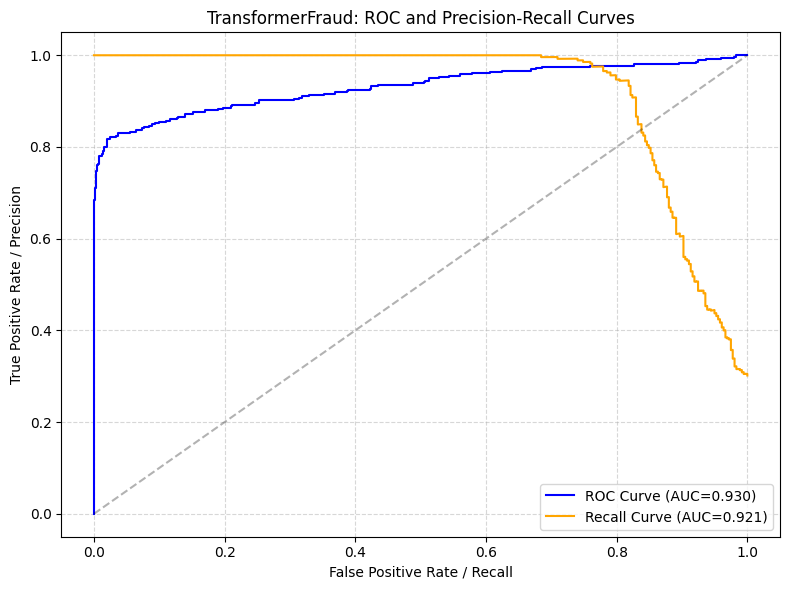

,Model,AUC,Recall,Precision,F1
0,XGBoost,0.8216,0.7283,0.5985,0.6571
1,Random Forest,0.8188,0.5577,0.7115,0.6253
2,LSTM,0.9292,0.8296,0.8813,0.8547
3,TransformerFraud,0.9305,0.8073,0.9444,0.8705


In [33]:
# ==============================================================
# ADDITION: Extended Transformer evaluation metrics + combined plot
# ==============================================================


# Convert probabilities to binary predictions
pred_label = (p_te >= threshold).astype(int)

# Compute additional metrics
precision = precision_score(yte, pred_label)
recall = recall_score(yte, pred_label)
f1 = f1_score(yte, pred_label)

print(f"[Transformer] Precision: {precision:.4f} | Recall: {recall:.4f} | F1-score: {f1:.4f}")

# Curves
fpr, tpr, _ = roc_curve(yte, p_te)
prec, rec, _ = precision_recall_curve(yte, p_te)

# Combined ROC and PR plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC={auc:.3f})", color='blue')
plt.plot(rec, prec, label=f"Recall Curve (AUC={ap:.3f})", color='orange')
plt.plot([0, 1], [0, 1], "k--", alpha=0.3)
plt.xlabel("False Positive Rate / Recall")
plt.ylabel("True Positive Rate / Precision")
plt.title("TransformerFraud: ROC and Precision-Recall Curves")
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
# ==============================================================
# SYNCED SUMMARY ENTRY — same structure as LSTM, RF, XGB
# ==============================================================


results = {"auc": auc, "recall": recall, "precision": precision, "f1": f1}

summary = append_to_summary(summary, "TransformerFraud", results)
display(summary)



#Pretrained

##TimesNet

###Install

In [34]:


# ============================
# 1️⃣ Clean up any old copies
# ============================
#!rm -rf /content/drive/MyDrive/Sem-6/coding/github/fraud_detection/Time-Series-Library

# ============================
# 2️⃣ Clone directly from gethub
# ============================
#!git clone https://github.com/thuml/Time-Series-Library.git /content/drive/MyDrive/Sem-6/coding/github/fraud_detection/Time-Series-Library

# ============================
# 3️⃣ Add repo to Python path
# ============================
import sys
sys.path.append('/content/drive/MyDrive/Sem-6/coding/github/fraud_detection/Time-Series-Library')

print("✅ Basic environment ready for TSLib!")

# ============================
# 4️⃣ Verify repo structure
# ============================
%cd /content/drive/MyDrive/Sem-6/coding/github/fraud_detection/Time-Series-Library
!ls -lh run.py




✅ Basic environment ready for TSLib!
/content/drive/MyDrive/Sem-6/coding/github/fraud_detection/Time-Series-Library
-rw------- 1 root root 15K Nov 10 17:42 run.py


#### Evaluate experiment

In [35]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)

def evaluate_experiment(
    results_dir: str,
    num_classes: int = None,
    class_labels=None,
    title: str = None,
    show_plot: bool = True,
):
    pred_path = os.path.join(results_dir, "pred.npy")
    true_path = os.path.join(results_dir, "true.npy")

    if not os.path.exists(pred_path) or not os.path.exists(true_path):
        raise FileNotFoundError(f"❌ Could not find pred.npy or true.npy in {results_dir}")

    pred = np.load(pred_path)
    true = np.load(true_path)

    # Ensure shape alignment
    true = true.flatten()
    pred = pred.flatten()

    # Basic metrics
    acc = accuracy_score(true, pred)
    prec = precision_score(true, pred, average="macro")
    rec = recall_score(true, pred, average="macro")
    f1 = f1_score(true, pred, average="macro")

    # ✅ Try to use probabilities if available for better AUC computation
    prob_path = os.path.join(results_dir, "prob.npy")
    if os.path.exists(prob_path):
        probs = np.load(prob_path)
        try:
            auc_val = roc_auc_score(true, probs) if len(np.unique(true)) == 2 else np.nan
        except:
            auc_val = np.nan
    else:
        # Handle AUC for binary only (fallback to predictions)
        try:
            auc_val = roc_auc_score(true, pred) if len(np.unique(true)) == 2 else np.nan
        except:
            auc_val = np.nan


    # Confusion matrix
    cm = confusion_matrix(true, pred)
    if class_labels is None:
        class_labels = [str(c) for c in np.unique(true)]

    # Plot confusion matrix
    if show_plot:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
        plt.figure(figsize=(8, 8))
        disp.plot(cmap="Blues", values_format="d", colorbar=False)
        plt.title(title or f"Confusion Matrix ({os.path.basename(results_dir)})")
        plt.show()

    # Print classification report
    print(f"\n📊 Accuracy: {acc:.4f}")
    print(f"📈 Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | AUC: {auc_val:.4f}")
    print("\nDetailed Report:")
    print(classification_report(true, pred, target_names=class_labels, digits=4))

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": auc_val,
        "confusion_matrix": cm,
    }


####Reproduce ▶

##### Reproduce Execute

In [36]:

# 2️⃣ Re-create a *real* checkpoints folder
!mkdir -p /content/drive/MyDrive/Sem-6/coding/github/fraud_detection/Time-Series-Library/checkpoints

# 3️⃣ Create the expected subfolder and copy your pretrained checkpoint
!mkdir -p "/content/drive/MyDrive/Sem-6/coding/github/fraud_detection/Time-Series-Library/checkpoints/classification_SpokenArabicDigits_TimesNet_UEA_ftM_sl93_ll48_pl0_dm32_nh8_el2_dl1_df32_expand2_dc4_fc1_ebtimeF_dtTrue_Pretrained_0"

!cp "/content/drive/MyDrive/Sem-6/coding/github/fraud_detection/Checkpints/TimesNet/classification/classification_SpokenArabicDigits_TimesNet_UEA_ftM_sl93_ll48_pl0_dm32_nh8_el2_dl1_df32_expand2_dc4_fc1_ebtimeF_dtTrue_Pretrained_0/checkpoint.pth" \
"/content/drive/MyDrive/Sem-6/coding/github/fraud_detection/Time-Series-Library/checkpoints/classification_SpokenArabicDigits_TimesNet_UEA_ftM_sl93_ll48_pl0_dm32_nh8_el2_dl1_df32_expand2_dc4_fc1_ebtimeF_dtTrue_Pretrained_0/checkpoint.pth"


In [37]:

!CUDA_VISIBLE_DEVICES=0 \
python -u /content/drive/MyDrive/Sem-6/coding/github/fraud_detection/Time-Series-Library/run.py \
  --task_name classification \
  --is_training 0 \
  --mode stat \
  --root_path /content/drive/MyDrive/Sem-6/coding/github/fraud_detection/ExternalDataset/TimesNet/classification/SpokenArabicDigits/ \
  --model_id SpokenArabicDigits \
  --model TimesNet \
  --data UEA \
  --gpu 0 \
  --use_gpu 1 \
  --e_layers 2 \
  --batch_size 16 \
  --d_model 32 \
  --d_ff 32 \
  --top_k 2 \
  --des 'Pretrained' \
  --itr 1 \
  --learning_rate 0.001 \
  --train_epochs 1 \
  --patience 10


Using GPU
Args in experiment:
Basic Config
  Task Name:          classification      Is Training:        0                   
  Model ID:           SpokenArabicDigits  Model:              TimesNet            

Data Loader
  Data:               UEA                 Root Path:          /content/drive/MyDrive/Sem-6/coding/github/fraud_detection/ExternalDataset/TimesNet/classification/SpokenArabicDigits/
  Data Path:          ETTh1.csv           Features:           M                   
  Target:             OT                  Freq:               h                   
  Checkpoints:        ./checkpoints/      

Model Parameters
  Top k:              2                   Num Kernels:        6                   
  Enc In:             7                   Dec In:             7                   
  C Out:              7                   d model:            32                  
  n heads:            8                   e layers:           2                   
  d layers:           1               

##### Reproduce Eval

In [38]:

# # Spoken Arabic Digits (10 classes)
# results  = evaluate_experiment(
#     "/content/drive/MyDrive/Sem-6/coding/github/fraud_detection/Time-Series-Library/test_results/classification_SpokenArabicDigits_TimesNet_UEA_ftM_sl93_ll48_pl0_dm32_nh8_el2_dl1_df32_expand2_dc4_fc1_ebtimeF_dtTrue_Pretrained_0",
#     num_classes=10,
#     title="Spoken Arabic Digits – TimesNet (Pretrained)"
# )


# summary = append_to_summary(summary, "TimesNet_Reproduce", results)
# display(summary)

### Data handling  

#### Covert  data to ts format

In [39]:
import os
import numpy as np

def write_ts_file(X, y, split_name, problem_name="FraudDataset", out_dir=None, pad_to_dim=None):
    """
    Writes data to .ts format compatible with sktime/aeon.

    Parameters
    ----------
    X : list or np.ndarray
        List of samples, each as 2D array [time_steps, features].
    y : list or np.ndarray
        Class labels (e.g., 0/1).
    split_name : str
        Split name, e.g., 'TRAIN' or 'TEST'.
    problem_name : str
        Dataset name.
    out_dir : str
        Directory to write output file to.
    pad_to_dim : int or None
        If given, pad or trim feature dimension to this number (e.g. 13).
    """
    if out_dir is None:
        out_dir = "/content/drive/MyDrive/Sem-6/coding/github/fraud_detection/ExternalDataset/TimesNet/classification/FraudDataset"
    os.makedirs(out_dir, exist_ok=True)
    ts_path = os.path.join(out_dir, f"{problem_name}_{split_name.upper()}.ts")

    with open(ts_path, "w") as f:
        f.write(f"@problemName {problem_name}\n")
        f.write("@timeStamps false\n")
        f.write("@univariate false\n")
        f.write("@classLabel true 0 1\n")
        f.write("@data\n")

        for i in range(len(X)):
            arr = np.array(X[i])

            # --- Pad or trim to target feature dimension ---
            if pad_to_dim is not None:
                if arr.ndim == 1:
                    arr = arr.reshape(-1, 1)
                n_dim = arr.shape[1]
                if n_dim < pad_to_dim:
                    pad = np.zeros((arr.shape[0], pad_to_dim - n_dim))
                    arr = np.hstack((arr, pad))
                elif n_dim > pad_to_dim:
                    arr = arr[:, :pad_to_dim]

            # --- Convert to string format ---
            if arr.ndim == 1:
                arr_str = ",".join(map(str, arr))
            else:
                parts = [",".join(map(str, arr[:, d])) for d in range(arr.shape[1])]
                arr_str = " : ".join(parts)  # colon separates dimensions

            f.write(f"{arr_str}:{int(y[i])}\n")

    print(f"✅ Wrote {ts_path} with {len(X)} samples (strict sktime format)")
    if pad_to_dim:
        print(f"📏 Feature dimensions padded/trimmed to {pad_to_dim}")


#### Convert

In [40]:

write_ts_file(X_train, y_train, split_name="TRAIN", pad_to_dim=13)
write_ts_file(X_test, y_test, split_name="TEST", pad_to_dim=13)


# write_ts_file(Xtr_raw, ytr, split_name="TRAIN")
# write_ts_file(Xte_raw, yte, split_name="TEST")

!ls -lh /content/drive/MyDrive/Sem-6/coding/github/fraud_detection/ExternalDataset/TimesNet/classification/FraudDataset/

from sktime.datasets import load_from_tsfile_to_dataframe

file_path = "/content/drive/MyDrive/Sem-6/coding/github/fraud_detection/ExternalDataset/TimesNet/classification/FraudDataset/FraudDataset_TRAIN.ts"
X, y = load_from_tsfile_to_dataframe(file_path)

print("✅ Loaded OK!")
print(X.shape)
print(set(y))


✅ Wrote /content/drive/MyDrive/Sem-6/coding/github/fraud_detection/ExternalDataset/TimesNet/classification/FraudDataset/FraudDataset_TRAIN.ts with 4742 samples (strict sktime format)
📏 Feature dimensions padded/trimmed to 13
✅ Wrote /content/drive/MyDrive/Sem-6/coding/github/fraud_detection/ExternalDataset/TimesNet/classification/FraudDataset/FraudDataset_TEST.ts with 1187 samples (strict sktime format)
📏 Feature dimensions padded/trimmed to 13
total 45M
-rw------- 1 root root 8.9M Nov 11 03:14 FraudDataset_TEST.ts
-rw------- 1 root root  36M Nov 11 03:14 FraudDataset_TRAIN.ts
-rw------- 1 root root 138K Nov 10 06:07 label.csv
drwx------ 2 root root 4.0K Nov 10 06:06 test
drwx------ 2 root root 4.0K Nov 10 06:06 train
drwx------ 2 root root 4.0K Nov 10 06:06 val
✅ Loaded OK!
(4742, 13)
{np.str_('1'), np.str_('0')}


#### Show sample

In [41]:
ts_dir = "/content/drive/MyDrive/Sem-6/coding/github/fraud_detection/ExternalDataset/TimesNet/classification/FraudDataset"

for fname in ["FraudDataset_TRAIN.ts", "FraudDataset_TEST.ts"]:
    fpath = os.path.join(ts_dir, fname)
    print(f" {fname}: exists = {os.path.exists(fpath)} | size = {os.path.getsize(fpath)/1024:.1f} KB")
    if os.path.exists(fpath):
        with open(fpath) as f:
            for i, line in enumerate(f):
                if i < 10:
                    print(line.strip())
                else:
                    break
        print("------\n")


 FraudDataset_TRAIN.ts: exists = True | size = 36367.0 KB
@problemName FraudDataset
@timeStamps false
@univariate false
@classLabel true 0 1
@data
-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.02566203660134207,-0.0256620366

#### Summrize

In [42]:
from sktime.datasets import load_from_tsfile_to_dataframe

file_path = "/content/drive/MyDrive/Sem-6/coding/github/fraud_detection/ExternalDataset/TimesNet/classification/FraudDataset/FraudDataset_TRAIN.ts"

X, y = load_from_tsfile_to_dataframe(file_path)

print("✅ File loaded successfully!")
print(f"Shape of X: {X.shape}")
print(f"Number of labels: {len(set(y))}")
print(f"Labels: {set(y)}")
#print(f"Example (first row):\n", X.iloc[0])

print("Feature ranges per column:")
for col in range(X.shape[1]):
    values = np.concatenate(X.iloc[:, col].values)
    print(f"Column {col}: mean={np.mean(values):.3f}, std={np.std(values):.3f}")


✅ File loaded successfully!
Shape of X: (4742, 13)
Number of labels: 2
Labels: {np.str_('1'), np.str_('0')}
Feature ranges per column:
Column 0: mean=0.170, std=5.352
Column 1: mean=0.027, std=1.372
Column 2: mean=-0.487, std=1.102
Column 3: mean=0.010, std=0.787
Column 4: mean=0.244, std=1.329
Column 5: mean=0.099, std=1.102
Column 6: mean=0.504, std=1.102
Column 7: mean=1.110, std=1.205
Column 8: mean=0.000, std=0.000
Column 9: mean=0.000, std=0.000
Column 10: mean=0.000, std=0.000
Column 11: mean=0.000, std=0.000
Column 12: mean=0.000, std=0.000


### Frozen layers ▶( randone projection)

##### Model

In [43]:
!mkdir -p ./checkpoints/classification_FraudDataset_TimesNet_UEA_ftM_sl50_ll48_pl0_dm32_nh8_el2_dl1_df32_expand2_dc4_fc1_ebtimeF_dtTrue_Frozen_Fraud_0

!cp "/content/drive/MyDrive/Sem-6/coding/github/fraud_detection/Checkpints/TimesNet/classification/classification_SpokenArabicDigits_TimesNet_UEA_ftM_sl93_ll48_pl0_dm32_nh8_el2_dl1_df32_expand2_dc4_fc1_ebtimeF_dtTrue_Pretrained_0/checkpoint.pth" \
"./checkpoints/classification_FraudDataset_TimesNet_UEA_ftM_sl50_ll48_pl0_dm32_nh8_el2_dl1_df32_expand2_dc4_fc1_ebtimeF_dtTrue_Frozen_Fraud_0/checkpoint.pth"

!CUDA_VISIBLE_DEVICES=0 \
python -u /content/drive/MyDrive/Sem-6/coding/github/fraud_detection/Time-Series-Library/run.py \
  --task_name classification \
  --is_training 0 \
  --mode frozen \
  --root_path /content/drive/MyDrive/Sem-6/coding/github/fraud_detection/ExternalDataset/TimesNet/classification/FraudDataset/ \
  --model_id FraudDataset \
  --model TimesNet \
  --data UEA \
  --data_path FraudDataset \
  --features M \
  --target OT \
  --gpu 0 \
  --use_gpu 1 \
  --batch_size 16 \
  --e_layers 2 \
  --d_model 32 \
  --d_ff 32 \
  --top_k 2 \
  --des "Frozen_Fraud" \
  --itr 1



Using GPU
Args in experiment:
Basic Config
  Task Name:          classification      Is Training:        0                   
  Model ID:           FraudDataset        Model:              TimesNet            

Data Loader
  Data:               UEA                 Root Path:          /content/drive/MyDrive/Sem-6/coding/github/fraud_detection/ExternalDataset/TimesNet/classification/FraudDataset/
  Data Path:          FraudDataset        Features:           M                   
  Target:             OT                  Freq:               h                   
  Checkpoints:        ./checkpoints/      

Model Parameters
  Top k:              2                   Num Kernels:        6                   
  Enc In:             7                   Dec In:             7                   
  C Out:              7                   d model:            32                  
  n heads:            8                   e layers:           2                   
  d layers:           1                   d 

##### Evaluation

<Figure size 800x800 with 0 Axes>

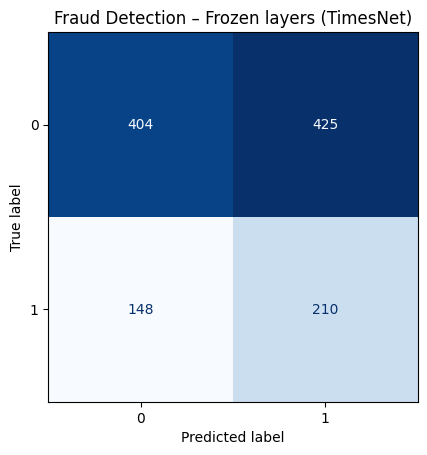


📊 Accuracy: 0.5173
📈 Precision: 0.5313 | Recall: 0.5370 | F1: 0.5040 | AUC: 0.5429

Detailed Report:
              precision    recall  f1-score   support

           0     0.7319    0.4873    0.5851       829
           1     0.3307    0.5866    0.4230       358

    accuracy                         0.5173      1187
   macro avg     0.5313    0.5370    0.5040      1187
weighted avg     0.6109    0.5173    0.5362      1187



,Model,AUC,Recall,Precision,F1
0,XGBoost,0.8216,0.7283,0.5985,0.6571
1,Random Forest,0.8188,0.5577,0.7115,0.6253
2,LSTM,0.9292,0.8296,0.8813,0.8547
3,TransformerFraud,0.9305,0.8073,0.9444,0.8705
4,TimesNet_FrozenLayers,0.5429,0.5370,0.5313,0.5040


In [44]:
# Evaluate the zero-shot fraud run
results = evaluate_experiment(
    "./test_results/classification_FraudDataset_TimesNet_UEA_ftM_sl50_ll48_pl0_dm32_nh8_el2_dl1_df32_expand2_dc4_fc1_ebtimeF_dtTrue_Frozen_Fraud_0",
    num_classes=2,  # Fraud vs Legitimate
    title="Fraud Detection – Frozen layers (TimesNet)"
)



summary = append_to_summary(summary, "TimesNet_FrozenLayers", results)
display(summary)



### Partial unfreeze ▶(classifier (head/fc/projection)

###### Model

In [45]:
!CUDA_VISIBLE_DEVICES=0 \
python -u /content/drive/MyDrive/Sem-6/coding/github/fraud_detection/Time-Series-Library/run.py \
  --task_name classification \
  --is_training 1 \
  --mode PartialUnfreeze \
  --root_path /content/drive/MyDrive/Sem-6/coding/github/fraud_detection/ExternalDataset/TimesNet/classification/FraudDataset/ \
  --model_id FraudDataset_PartialUnfreeze \
  --model TimesNet \
  --data UEA \
  --data_path FraudDataset \
  --features M \
  --target OT \
  --gpu 0 \
  --use_gpu 1 \
  --batch_size 8 \
  --train_epochs 10 \
  --learning_rate 1e-4 \
  --e_layers 2 \
  --d_model 32 \
  --d_ff 32 \
  --top_k 2 \
  --des "PartialUnfreeze_Fraud_HeadOnly" \
  --itr 1


Using GPU
Args in experiment:
Basic Config
  Task Name:          classification      Is Training:        1                   
  Model ID:           FraudDataset_PartialUnfreezeModel:              TimesNet            

Data Loader
  Data:               UEA                 Root Path:          /content/drive/MyDrive/Sem-6/coding/github/fraud_detection/ExternalDataset/TimesNet/classification/FraudDataset/
  Data Path:          FraudDataset        Features:           M                   
  Target:             OT                  Freq:               h                   
  Checkpoints:        ./checkpoints/      

Model Parameters
  Top k:              2                   Num Kernels:        6                   
  Enc In:             7                   Dec In:             7                   
  C Out:              7                   d model:            32                  
  n heads:            8                   e layers:           2                   
  d layers:           1             

###### Evaluation

<Figure size 800x800 with 0 Axes>

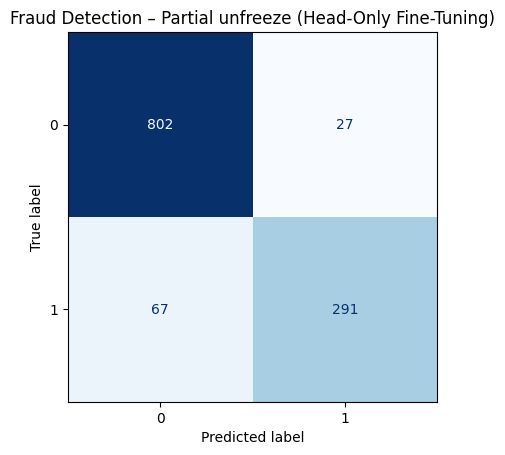


📊 Accuracy: 0.9208
📈 Precision: 0.9190 | Recall: 0.8901 | F1: 0.9028 | AUC: 0.9197

Detailed Report:
              precision    recall  f1-score   support

           0     0.9229    0.9674    0.9446       829
           1     0.9151    0.8128    0.8609       358

    accuracy                         0.9208      1187
   macro avg     0.9190    0.8901    0.9028      1187
weighted avg     0.9205    0.9208    0.9194      1187



,Model,AUC,Recall,Precision,F1
0,XGBoost,0.8216,0.7283,0.5985,0.6571
1,Random Forest,0.8188,0.5577,0.7115,0.6253
2,LSTM,0.9292,0.8296,0.8813,0.8547
3,TransformerFraud,0.9305,0.8073,0.9444,0.8705
4,TimesNet_FrozenLayers,0.5429,0.5370,0.5313,0.5040
5,TimesNet_Partial unfreeze,0.9197,0.8901,0.9190,0.9028


In [46]:
results = evaluate_experiment(
    "./test_results/classification_FraudDataset_PartialUnfreeze_TimesNet_UEA_ftM_sl50_ll48_pl0_dm32_nh8_el2_dl1_df32_expand2_dc4_fc1_ebtimeF_dtTrue_PartialUnfreeze_Fraud_HeadOnly_0",
    num_classes=2,
    title="Fraud Detection – Partial unfreeze (Head-Only Fine-Tuning)"
)


summary = append_to_summary(summary, "TimesNet_Partial unfreeze", results)
display(summary)



###Unfrozen (full fine-tuning)

#### Model

In [47]:
!CUDA_VISIBLE_DEVICES=0 \
python -u /content/drive/MyDrive/Sem-6/coding/github/fraud_detection/Time-Series-Library/run.py \
  --task_name classification \
  --is_training 1 \
  --mode Unfrozen \
  --root_path /content/drive/MyDrive/Sem-6/coding/github/fraud_detection/ExternalDataset/TimesNet/classification/FraudDataset/ \
  --model_id FraudDataset_Unfrozen \
  --model TimesNet \
  --data UEA \
  --data_path FraudDataset \
  --features M \
  --target OT \
  --gpu 0 \
  --use_gpu 1 \
  --batch_size 16 \
  --train_epochs 10 \
  --learning_rate 1e-4 \
  --e_layers 2 \
  --d_model 32 \
  --d_ff 32 \
  --top_k 2 \
  --des "Unfrozen_Fraud_AllLayers" \
  --itr 1


Using GPU
Args in experiment:
Basic Config
  Task Name:          classification      Is Training:        1                   
  Model ID:           FraudDataset_UnfrozenModel:              TimesNet            

Data Loader
  Data:               UEA                 Root Path:          /content/drive/MyDrive/Sem-6/coding/github/fraud_detection/ExternalDataset/TimesNet/classification/FraudDataset/
  Data Path:          FraudDataset        Features:           M                   
  Target:             OT                  Freq:               h                   
  Checkpoints:        ./checkpoints/      

Model Parameters
  Top k:              2                   Num Kernels:        6                   
  Enc In:             7                   Dec In:             7                   
  C Out:              7                   d model:            32                  
  n heads:            8                   e layers:           2                   
  d layers:           1                   d

####  Evaluation

<Figure size 800x800 with 0 Axes>

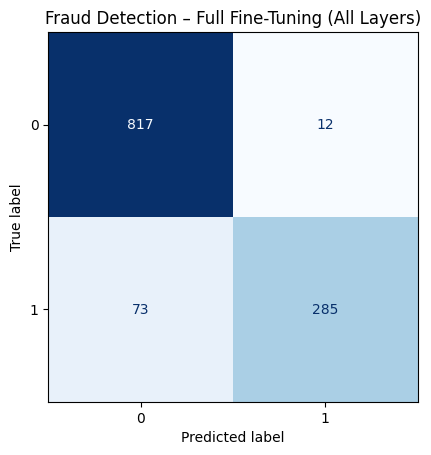


📊 Accuracy: 0.9284
📈 Precision: 0.9388 | Recall: 0.8908 | F1: 0.9104 | AUC: 0.9258

Detailed Report:
              precision    recall  f1-score   support

           0     0.9180    0.9855    0.9506       829
           1     0.9596    0.7961    0.8702       358

    accuracy                         0.9284      1187
   macro avg     0.9388    0.8908    0.9104      1187
weighted avg     0.9305    0.9284    0.9263      1187



,Model,AUC,Recall,Precision,F1
0,XGBoost,0.8216,0.7283,0.5985,0.6571
1,Random Forest,0.8188,0.5577,0.7115,0.6253
2,LSTM,0.9292,0.8296,0.8813,0.8547
3,TransformerFraud,0.9305,0.8073,0.9444,0.8705
4,TimesNet_FrozenLayers,0.5429,0.5370,0.5313,0.5040
5,TimesNet_Partial unfreeze,0.9197,0.8901,0.9190,0.9028
6,TimesNet_Unfrozen,0.9258,0.8908,0.9388,0.9104


In [48]:
results = evaluate_experiment(
    "./test_results/classification_FraudDataset_Unfrozen_TimesNet_UEA_ftM_sl50_ll48_pl0_dm32_nh8_el2_dl1_df32_expand2_dc4_fc1_ebtimeF_dtTrue_Unfrozen_Fraud_AllLayers_0",
    num_classes=2,
    title="Fraud Detection – Full Fine-Tuning (All Layers)"
)

summary = append_to_summary(summary, "TimesNet_Unfrozen", results)
display(summary)


#freeze

In [49]:
%pip freeze > "{project_path}requirement/freez/EnhancedPretraindMLModleAdvance-lock.txt"